In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 14})

import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import tensorflow_addons as tfa
import pickle
import random
import math
import os
import glob
import sys
import argparse
import datetime
import subprocess
import wispy
import wispy.resnet
import wispy.logger
import wispy.utils
import wispy.callbacks
import wispy.model_utils
from tomlkit import parse
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import wispy.mscalev2
import wispy.mscalev3
import wispy.mscalev4
import wispy.mscalev4
import wispy.mscalev5

In [4]:
sys.path.append('..')
from compute_preprocessing import apply_pre_process_forward

In [5]:
import fit

In [6]:
%matplotlib inline

In [7]:
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [8]:
!ls dataset_0

compute_preprocessing.toml           run-gen-training.sh
data_generation_coprec_training.toml run-preproc.sh
data_generation_coprec_val.toml      training_data
data_logs                            validation_data
pre_processing


In [9]:
!ls dataset_0/training_data/

alpha.npy  amp_22.npy coords.npy phi_21.npy times.npy
amp_21.npy beta.npy   gamma.npy  phi_22.npy


In [10]:
!ls dataset_0/pre_processing/

preprocessing_params.npz times_scaler.pkl


In [97]:
def get_training_data(dataset_dir='dataset_0', data_to_model='alpha', batch_size=32, t_batch_size=100, subtraction=False):
    coords_train = np.load(os.path.join(dataset_dir, 'training_data/coords.npy'))
    coords_train = coords_train.T

    # load times data
    times = np.load(os.path.join(dataset_dir, 'training_data/times.npy'))

    pkl_filename = os.path.join(dataset_dir, 'pre_processing/times_scaler.pkl')
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)

    times_scaled = times_scaler.transform(times[:, np.newaxis])

    # based on `data_to_model` decide which data to load

    filename = os.path.join(dataset_dir, 'pre_processing/preprocessing_params.npz')
    y_processing_params = np.load(filename)

    y_train = fit.load_coprec_data_and_apply_preproc(
        f'{dataset_dir}/training_data', data_to_model, y_processing_params)
    output_shape = 1
        
    input_shape = coords_train.shape[1] + 1  # add one for time
    
    if subtraction:
        y_train = y_train - y_train[:,0][:, np.newaxis]

    train_dataset = fit.DataGenv2(
        X=coords_train,
        t=times_scaled,
        y=y_train,
        X_batch_size=batch_size,
        t_batch_size=t_batch_size,
        output_shape=output_shape,
        shuffle=True)

#     del coords_train
#     del y_train

    return train_dataset, input_shape, output_shape, coords_train, times_scaled, y_train

# gamma

In [52]:
train_dataset, input_shape, output_shape, coords, times_scaled, y_train = \
    get_training_data(dataset_dir='dataset_2', data_to_model='gamma', batch_size=32, t_batch_size=500)

In [53]:
y_train.shape

(1, 1220)

In [54]:
model_params=dict(
    input_shape=input_shape,
    output_shape=output_shape,
    units=[128,128],
    activation="s2relu",
    scale_activation="s2relu",
    n_blocks=[1,1],
    scales=[1,10],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,

)

In [55]:
model = wispy.mscalev5.build_model(**model_params)

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [57]:
callbacks = [
    wispy.callbacks.ThresholdCallback(1e-7),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, min_lr=1e-6, factor=0.8)
            ]

In [58]:
%%time
history = model.fit(train_dataset, epochs=800, verbose=0, callbacks=callbacks)

CPU times: user 30.1 s, sys: 7.99 s, total: 38 s
Wall time: 18.4 s


In [59]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

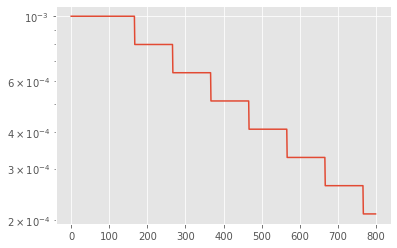

In [60]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

In [61]:
def make_prediction(model, times, coords):
    xx = np.column_stack(
        (times[:, 0], (coords*np.ones(times_scaled.shape))))
    yhat = model.predict(xx)

    return yhat

In [64]:
index = 0
yhat = make_prediction(model, times_scaled, coords[index])
plt.figure()
plt.plot(times_scaled, y_train[index])
plt.plot(times_scaled, yhat)
plt.figure()
plt.plot(times_scaled, y_train[index]-yhat[:,0])

# alpha

In [65]:
train_dataset, input_shape, output_shape, coords, times_scaled, y_train = \
    get_training_data(dataset_dir='dataset_2', data_to_model='alpha', batch_size=32, t_batch_size=500)

In [66]:
model_params=dict(
    input_shape=input_shape,
    output_shape=output_shape,
    units=[128,128],
    activation="s2relu",
    scale_activation="s2relu",
    n_blocks=[1,1],
    scales=[1,10],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,

)

In [67]:
model = wispy.mscalev5.build_model(**model_params)

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [69]:
callbacks = [
    wispy.callbacks.ThresholdCallback(1e-7),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, min_lr=1e-6, factor=0.8)
            ]

In [70]:
%%time
history = model.fit(train_dataset, epochs=800, verbose=0, callbacks=callbacks)

CPU times: user 1min 27s, sys: 48.4 s, total: 2min 15s
Wall time: 31.2 s


In [71]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

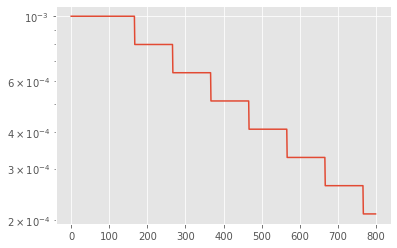

In [72]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

In [73]:
def make_prediction(model, times, coords):
    xx = np.column_stack(
        (times[:, 0], (coords*np.ones(times_scaled.shape))))
    yhat = model.predict(xx)

    return yhat

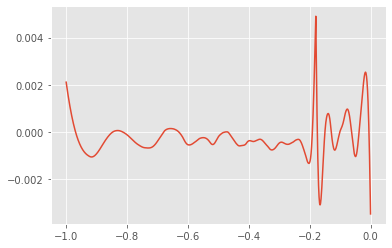

In [75]:
index = 0
yhat = make_prediction(model, times_scaled, coords[index])
plt.figure()
plt.plot(times_scaled, y_train[index])
plt.plot(times_scaled, yhat)
plt.figure()
plt.plot(times_scaled, y_train[index]-yhat[:,0])

# beta without subtraction

In [118]:
train_dataset, input_shape, output_shape, coords, times_scaled, y_train = \
    get_training_data(dataset_dir='dataset_1', data_to_model='beta', batch_size=32, t_batch_size=500, subtraction=False)

In [119]:
model_params=dict(
    input_shape=input_shape,
    output_shape=output_shape,
    units=[128,128],
    activation="s2relu",
    scale_activation="s2relu",
    n_blocks=[1,1],
    scales=[1,10],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,

)

In [120]:
model = wispy.mscalev5.build_model(**model_params)

In [121]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [122]:
callbacks = [
    wispy.callbacks.ThresholdCallback(1e-7),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, min_lr=1e-6, factor=0.8)
            ]

In [123]:
%%time
history = model.fit(train_dataset, epochs=800, verbose=0, callbacks=callbacks)

CPU times: user 1min 29s, sys: 50.8 s, total: 2min 20s
Wall time: 33.1 s


In [124]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

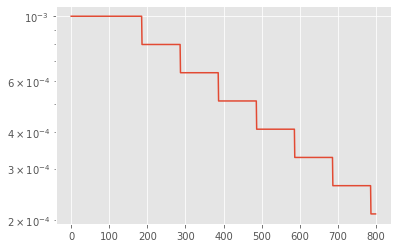

In [125]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

In [126]:
def make_prediction(model, times, coords):
    xx = np.column_stack(
        (times[:, 0], (coords*np.ones(times_scaled.shape))))
    yhat = model.predict(xx)

    return yhat

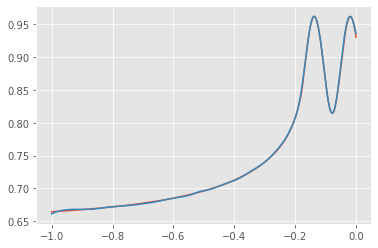

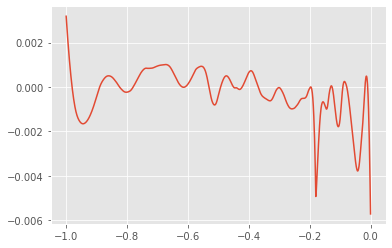

In [127]:
index = 0
yhat = make_prediction(model, times_scaled, coords[index])
plt.figure()
plt.plot(times_scaled, y_train[index])
plt.plot(times_scaled, yhat)
plt.figure()
plt.plot(times_scaled, y_train[index]-yhat[:,0])

# beta with subtraction

In [128]:
train_dataset, input_shape, output_shape, coords, times_scaled, y_train = \
    get_training_data(dataset_dir='dataset_1', data_to_model='beta', batch_size=32, t_batch_size=500, subtraction=True)

In [129]:
model_params=dict(
    input_shape=input_shape,
    output_shape=output_shape,
    units=[128,128],
    activation="s2relu",
    scale_activation="s2relu",
    n_blocks=[1,1],
    scales=[1,10],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,

)

In [130]:
model = wispy.mscalev5.build_model(**model_params)

In [131]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [132]:
callbacks = [
    wispy.callbacks.ThresholdCallback(1e-7),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, min_lr=1e-6, factor=0.8)
            ]

In [133]:
%%time
history = model.fit(train_dataset, epochs=800, verbose=0, callbacks=callbacks)

CPU times: user 1min 29s, sys: 48.8 s, total: 2min 18s
Wall time: 34.2 s


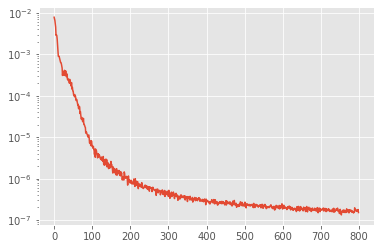

In [134]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')

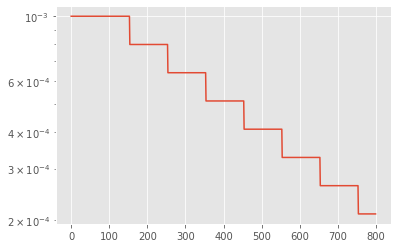

In [135]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

In [136]:
def make_prediction(model, times, coords):
    xx = np.column_stack(
        (times[:, 0], (coords*np.ones(times_scaled.shape))))
    yhat = model.predict(xx)

    return yhat

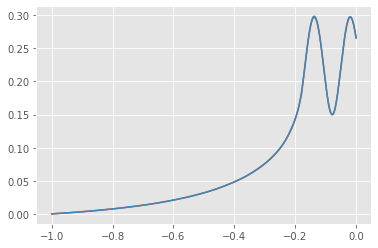

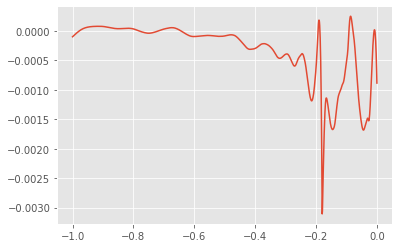

In [137]:
index = 0
yhat = make_prediction(model, times_scaled, coords[index])
plt.figure()
plt.plot(times_scaled, y_train[index])
plt.plot(times_scaled, yhat)
plt.figure()
plt.plot(times_scaled, y_train[index]-yhat[:,0])